The final questionnaire consists of 20 questions

In [42]:
import pandas as pd
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import shap

In [43]:
# load the screening questionnaire 
screening_questions = pd.read_csv('screening_questions_final.csv', sep=';')

# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

# oversampling
adasyn = ADASYN(random_state=38)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)

# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, stratify=y_women, random_state=15) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.35, stratify=y_train_val_women, random_state=15) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, stratify=y_men, random_state=15) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.35, stratify=y_train_val_men, random_state=15) 

In [4]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2, scoring='accuracy')
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

Best performing models on 20 question questionnaire

K-Nearest Neighbours for Women

In [49]:
knn_women = KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='euclidean')
knn_women.fit(X_train_val_women, y_train_val_women)

knn_women_perm_importance = permutation_importance(knn_women, X_test_women, y_test_women, n_repeats=30, random_state=15)

feature_importance_df_knn = pd.DataFrame({
    'question_code': X_train_val_women.columns,
    'feature_importance': knn_women_perm_importance.importances_mean
})
merged_df_women = pd.merge(screening_questions, feature_importance_df_knn, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
merged_df_women = merged_df_women.drop(columns=['Critère DSM-5']).copy()
merged_df_women.head(20)

#print("Feature Importance for Women:")
#for importance, name in sorted(zip(knn_women_perm_importance.importances_mean, X_train_val_women.columns), reverse=True):
#    print(f"{name}: {importance}")

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
19,I often impose myself in conversations.,tr43,"Often interrupts or intrudes on others (e.g., ...",hyperactivity/impulsivity,0.045370
14,I have trouble sitting still,tr27,Often fidgets with or taps hands or feet or sq...,hyperactivity/impulsivity,0.025926
15,I often leave my seat unnecessarily during a m...,tr28,Often leaves seat in situations when remaining...,hyperactivity/impulsivity,0.018519
17,The people around me find me to be an impatien...,tr35,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.015741
10,I often lose things I need for my activities/l...,tr20,Often loses things necessary for tasks or acti...,inattention,0.015741
5,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention,0.014815
16,I often show my impatience in inappropriate ci...,tr32,Often runs about or climbs in situations where...,hyperactivity/impulsivity,0.002778
4,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention,0.000926
3,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention,0.000926
11,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.000926


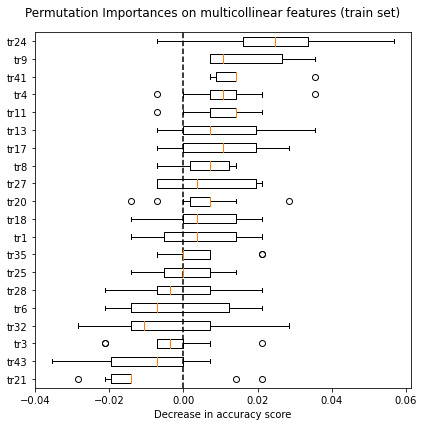

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(knn_women, X_train_val_women, y_train_val_women, ax)
ax.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Permutation Importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

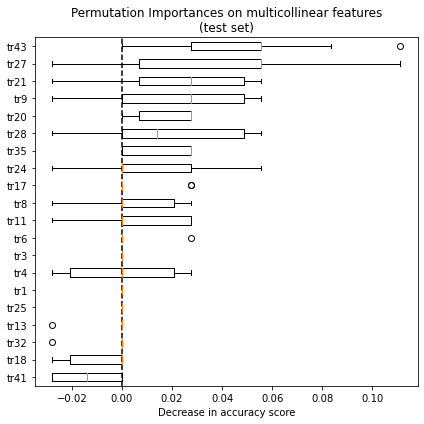

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(knn_women, X_test_women, y_test_women, ax)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

In [8]:
# Initialize a SHAP explainer object
explainer = shap.KernelExplainer(knn_women.predict_proba, X_train_val_women)

# Calculate SHAP values for the test set
shap_values_women = explainer.shap_values(X_test_women)

Using 141 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


100%|██████████| 36/36 [01:52<00:00,  3.13s/it]


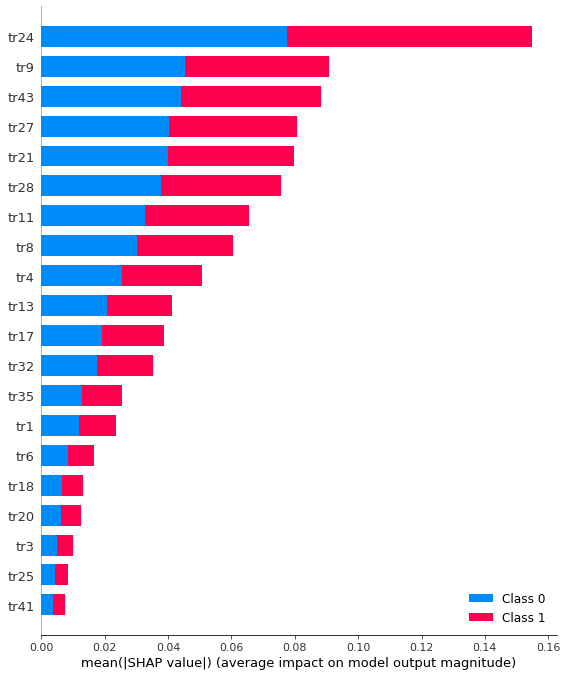

In [53]:
# Visualize the SHAP values
shap.summary_plot(shap_values_women, X_test_women)

In [110]:
np.abs(shap_values_women).shape
aggs = np.abs(shap_values_women).mean(1)

shap_values_women_df = pd.DataFrame(aggs.T) 

shap_values_women_df['feature_importance'] = shap_values_women_df[0] + shap_values_women_df[1]
shap_values_women_df['question_code'] = X_test_women.columns
shap_values_women_df = shap_values_women_df.drop(columns=[0, 1]).sort_values(by='feature_importance', ascending=False)

shap_merged_df_women = pd.merge(screening_questions, shap_values_women_df, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
shap_merged_df_women = shap_merged_df_women.drop(columns=['Critère DSM-5']).copy()
shap_merged_df_women.head(20)

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
12,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.154915
5,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention,0.090727
19,I often impose myself in conversations.,tr43,"Often interrupts or intrudes on others (e.g., ...",hyperactivity/impulsivity,0.088279
14,I have trouble sitting still,tr27,Often fidgets with or taps hands or feet or sq...,hyperactivity/impulsivity,0.080836
11,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.079659
15,I often leave my seat unnecessarily during a m...,tr28,Often leaves seat in situations when remaining...,hyperactivity/impulsivity,0.075640
6,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention,0.065673
4,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention,0.060616
2,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention,0.050672
7,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention,0.041301


Random Forest for Men

In [51]:
rf_men = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2',
                                min_samples_leaf=2, min_samples_split=2, n_estimators=50)
rf_men.fit(X_train_val_men, y_train_val_men)

rf_men_perm_importance = permutation_importance(rf_men, X_train_val_men, y_train_val_men, n_repeats=30, random_state=15)

feature_importance_df_rf = pd.DataFrame({
    'question_code': X_train_val_men.columns,
    'feature_importance': rf_men_perm_importance.importances_mean
})
merged_df_men = pd.merge(screening_questions, feature_importance_df_rf, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
merged_df_men = merged_df_men.drop(columns=['Critère DSM-5']).copy()
merged_df_men.head(20)

#print("Feature Importance for Men:")
#for importance, name in sorted(zip(rf_men_perm_importance.importances_mean, X_train_val_men.columns), reverse=True):
#    print(f"{name}: {importance}")

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
12,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.046853
0,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention,0.031235
7,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention,0.027972
15,I often leave my seat unnecessarily during a m...,tr28,Often leaves seat in situations when remaining...,hyperactivity/impulsivity,0.019814
1,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention,0.017716
17,The people around me find me to be an impatien...,tr35,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.017483
3,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention,0.015152
2,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention,0.013287
11,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.011655
8,I tend to operate at the last minute,tr17,"Often avoids, dislikes, or is reluctant to eng...",inattention,0.010956


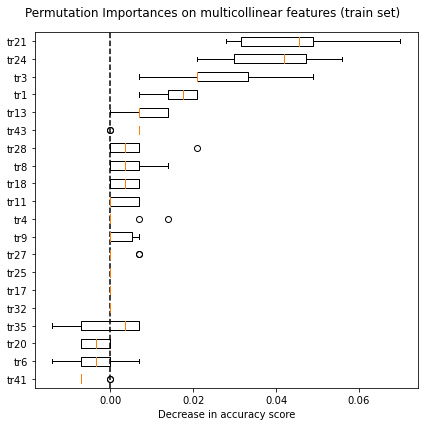

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(rf_men, X_train_val_men, y_train_val_men, ax)
ax.set_xlabel("Decrease in accuracy score")
fig.suptitle("Permutation Importances on multicollinear features (train set)")
_ = fig.tight_layout()

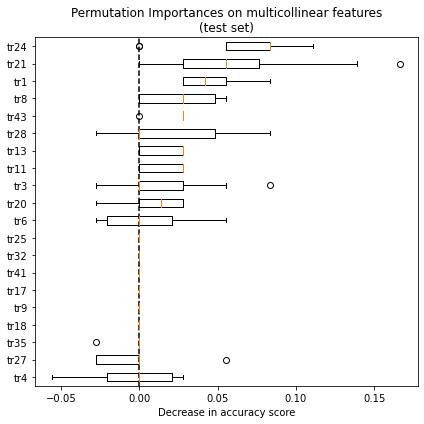

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_permutation_importance(rf_men, X_test_men, y_test_men, ax)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

In [15]:
# Initialize a SHAP (SHapley Additive exPlanations) explainer object
explainer = shap.TreeExplainer(rf_men, X_train_val_men)

# Calculate SHAP values for the test set
shap_values_men = explainer.shap_values(X_test_men)

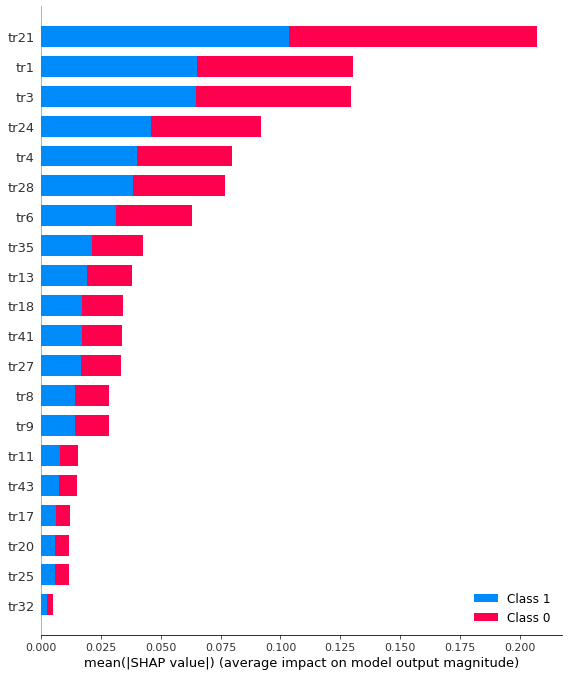

In [23]:
# Visualize the SHAP values
shap.summary_plot(shap_values_men, X_test_men)

In [108]:
np.abs(shap_values_men).shape
aggs = np.abs(shap_values_men).mean(1)

shap_values_men_df = pd.DataFrame(aggs.T) 

shap_values_men_df['feature_importance'] = shap_values_men_df[0] + shap_values_men_df[1]
shap_values_men_df['question_code'] = X_test_men.columns
shap_values_men_df = shap_values_men_df.drop(columns=[0, 1]).sort_values(by='feature_importance', ascending=False)

shap_merged_df_men = pd.merge(screening_questions, shap_values_men_df, on='question_code', how='inner').sort_values(by='feature_importance', ascending=False)
shap_merged_df_men = shap_merged_df_men.drop(columns=['Critère DSM-5']).copy()
shap_merged_df_men.head(20)

,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category,feature_importance
11,I am easily distracted by my environment,tr21,Is often easily distracted by extraneous stimu...,inattention,0.207192
0,I don't really pay attention to details,tr1,Often fails to give close attention to details...,inattention,0.130356
1,I often make careless mistakes in my activities,tr3,Often fails to give close attention to details...,inattention,0.129629
12,I am often subject to forgetfulness in my dail...,tr24,"Is often forgetful in daily activities (e.g., ...",inattention,0.091973
2,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention,0.079878
15,I often leave my seat unnecessarily during a m...,tr28,Often leaves seat in situations when remaining...,hyperactivity/impulsivity,0.076744
3,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention,0.062803
17,The people around me find me to be an impatien...,tr35,"Is often “on the go,” acting as if “driven by ...",hyperactivity/impulsivity,0.042387
7,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention,0.037991
9,I often lose things I need for my daily life,tr18,Often loses things necessary for tasks or acti...,inattention,0.034062


In [92]:
#feature_importance_men = rf_men.feature_importances_
#print("\nFeature Importance for Men:")
#for name, importance in zip(X_train_val_men.columns, feature_importance_men):
#    print(f"{name}: {importance}")